In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

didiersalazar_lab2_dataset_path = kagglehub.dataset_download('didiersalazar/lab2-dataset')
didiersalazar_pictures_path = kagglehub.dataset_download('didiersalazar/pictures')
didiersalazar_google_news_vectors_path = kagglehub.dataset_download('didiersalazar/google-news-vectors')

print('Data source import complete.')


Data source import complete.


In [2]:
didiersalazar_pictures_path

'C:\\Users\\james\\.cache\\kagglehub\\datasets\\didiersalazar\\pictures\\versions\\1'

In [3]:
# import library
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import umap
import gensim
import tensorflow
import keras
import ollama
import langchain
import langchain_community
import langchain_core
import bs4
import chromadb
import gradio

%matplotlib inline

print("gensim: " + gensim.__version__)
print("tensorflow: " + tensorflow.__version__)
print("keras: " + keras.__version__)

gensim: 4.3.3
tensorflow: 2.18.0
keras: 3.6.0


# Data Mining Lab 2
In this lab session we will focus on the use of Neural Word Embeddings and exploring some basic open source LLMs' applications to data.

## Table of Contents
1. Data preparation
2. Feature engineering
3. Model
4. Results evaluation
5. Other things you could try
6. Deep Learning
7. Word to Vector
8. Clustering
9. High-dimension Visualization
10. Large Language Models (LLMs)


### Necessary Library Requirements:

#### Same as Lab1 except PAMI:
- [Jupyter](http://jupyter.org/) (Strongly recommended but not required)
    - Install via `pip3 install jupyter` and use `jupyter notebook` in terminal to run
- [Scikit Learn](http://scikit-learn.org/stable/index.html)
    - Install via `pip3 install scikit-learn` from a terminal
- [Pandas](http://pandas.pydata.org/)
    - Install via `pip3 install pandas` from a terminal
- [Numpy](http://www.numpy.org/)
    - Install via `pip3 install numpy` from a terminal
- [Matplotlib](https://matplotlib.org/)
    - Install via `pip3 install maplotlib` from a terminal
- [Plotly](https://plot.ly/)
    - Install via `pip3 install plotly` from a terminal
- [Seaborn](https://seaborn.pydata.org/)
    - Install via `pip3 install seaborn`
- [NLTK](http://www.nltk.org/)
    - Install via `pip3 install nltk` from a terminal
- [UMAP](https://umap-learn.readthedocs.io/en/latest/)
    - Install via `pip3 install umap-learn` from a terminal
    

#### New Libraries to install:
- [Gensim](https://pypi.org/project/gensim/)
    - Install via `pip3 install gensim`

- [tensorflow](https://www.tensorflow.org/)
    - Install via `pip3 install tensorflow`
    - Also install `pip3 install tensorflow-hub`

- [Keras](https://keras.io/)
    - Install via `pip3 install keras`

- [Ollama](https://ollama.com)
    - Install via `pip3 install ollama`

- [langchain](https://www.langchain.com)
    - Install via `pip3 install langchain`
    - Also install `pip3 install langchain_community`
    - Also install `pip3 install langchain_core`
    
- [beautifulsoup4](https://pypi.org/project/beautifulsoup4/)
    - Install via `pip3 install beautifulsoup4`
    
- [chromadb](https://www.trychroma.com)
    - Install via `pip3 install chromadb`
    
- [gradio](https://www.gradio.app)
    - Install via `pip3 install gradio`
    
#### Open-source LLMs to install:
- ollama run llama3.2
- ollama run llama3.2:1b  (optional if the first one is too big)
- ollama run llava-phi3

---
## Introduction

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic0.png?raw=true)

---
## 1. Data Preparation

Before beggining the lab, please make sure to download the [Google News Dataset](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) and place it in a folder named "GoogleNews" in the same directory as this file.

## 1.1 Load data

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [4]:
import pandas as pd

### training data
anger_train = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [5]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [6]:
### testing data
anger_test = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv(f"{didiersalazar_lab2_dataset_path}/data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [7]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [8]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def do_exercise1(df):
    # count word frequency
    vectorizer = CountVectorizer()
    count = vectorizer.fit_transform(df.text)
    frequencies = np.asarray(count.sum(axis=0))[0]
    # sort in decreasing order
    sorted_idx = np.argsort(frequencies)[::-1]
    # plot
    plt.subplots(figsize=(20, 2))
    g = sns.barplot(x=vectorizer.get_feature_names_out()[sorted_idx][:30],
                    y=frequencies[sorted_idx][:30])
    g.set_xticklabels(vectorizer.get_feature_names_out()[sorted_idx][:30], rotation = 90);

C:\Users\james\AppData\Local\Temp\ipykernel_12296\3818085132.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(vectorizer.get_feature_names_out()[sorted_idx][:30], rotation = 90);


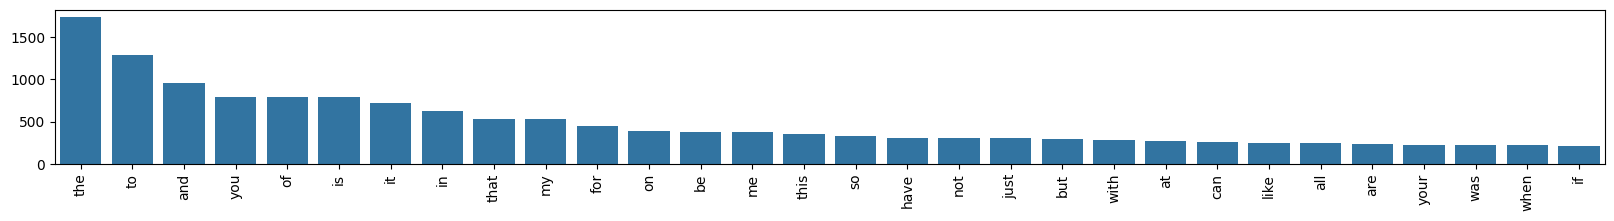

In [11]:
do_exercise1(train_df)

C:\Users\james\AppData\Local\Temp\ipykernel_12296\3818085132.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(vectorizer.get_feature_names_out()[sorted_idx][:30], rotation = 90);


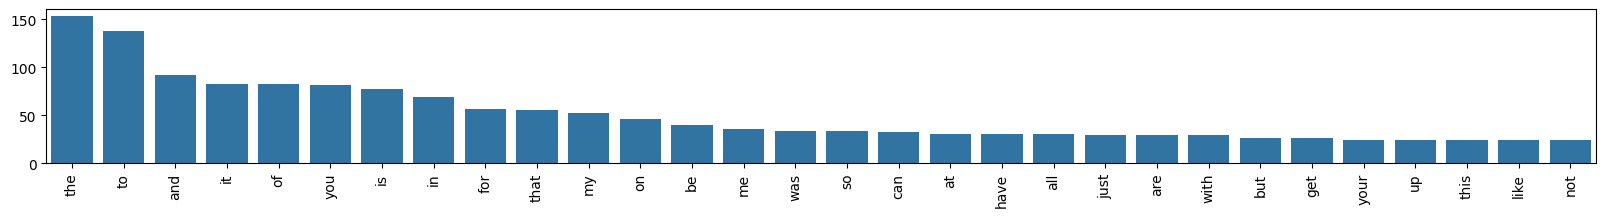

In [12]:
do_exercise1(test_df)

---
### 1.2 Save data

We will save our data in Pickle format. The pickle module implements binary protocols for serializing and de-serializing a Python object structure.   
  
Some advantages for using pickle structure:  
* Because it stores the attribute type, it's more convenient for cross-platform use.  
* When your data is huge, it could use less space to store also consume less loading time.   

In [13]:
## save to pickle file
train_df.to_pickle("train_df.pkl")
test_df.to_pickle("test_df.pkl")

In [14]:
import pandas as pd

## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
### 1.3 Exploratory data analysis (EDA)

Again, before getting our hands dirty, we need to explore a little bit and understand the data we're dealing with.

In [15]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

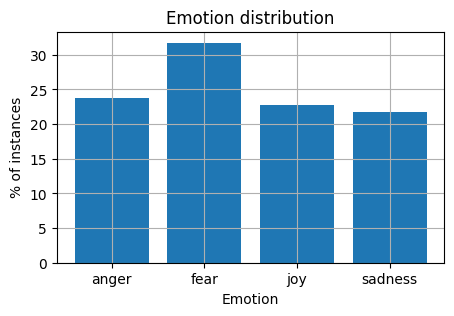

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---

## 2. Feature engineering
### Using Bag of Words
Using scikit-learn ```CountVectorizer``` perform word frequency and use these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer()

In [19]:
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(train_df['text'])

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(train_df['text'])
test_data_BOW_features = BOW_vectorizer.transform(test_df['text'])

In [20]:
# check the result
train_data_BOW_features

<3613x10115 sparse matrix of type '<class 'numpy.int64'>'
	with 51467 stored elements in Compressed Sparse Row format>

In [21]:
type(train_data_BOW_features)

scipy.sparse._csr.csr_matrix

In [22]:
# add .toarray() to show
train_data_BOW_features.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
# check the dimension
train_data_BOW_features.shape

(3613, 10115)

In [24]:
# observe some feature names
feature_names = BOW_vectorizer.get_feature_names_out()
feature_names[100:110]

array(['2k17', '2much', '2nd', '30', '300', '301', '30am', '30pm', '30s',
       '31'], dtype=object)

The embedding is done. We can technically feed this into our model. However, depending on the embedding technique you use and your model, your accuracy might not be as high, because:

* curse of dimensionality  (we have 10,115 dimension now)
* some important features are ignored (for example, some models using emoticons yeld better performance than counterparts)

In [25]:
"😂" in feature_names

False

Let's try using another tokenizer below.

In [26]:
import nltk
nltk.download('punkt_tab')
# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize)

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

## check dimension
train_data_BOW_features_500.shape

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
c:\Users\james\anaconda3\envs\DataMining\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(3613, 500)

In [27]:
train_data_BOW_features_500.toarray()

array([[0, 7, 0, ..., 0, 0, 0],
       [1, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [28]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names_out()
feature_names_500[100:110]

array(['change', 'cheer', 'cheerful', 'cheerfully', 'cheering', 'cheery',
       'come', 'comes', 'could', 'country'], dtype=object)

In [29]:
"😂" in feature_names_500

True

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vectorizer = TfidfVectorizer(max_features=1000)
Tfidf_vectorizer.fit(train_df['text'])
# check dimension
train_data_tfidf_features_500 = Tfidf_vectorizer.transform(train_df['text'])
print("shape:", train_data_tfidf_features_500.shape)
Tfidf_vectorizer.get_feature_names_out()[100:110]

shape: (3613, 1000)


array(['bitter', 'black', 'blacks', 'blame', 'blessed', 'blood', 'bloody',
       'blues', 'body', 'boiling'], dtype=object)

In [31]:
# use nltk tokenizer to see the difference
Tfidf_vectorizer = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize)
Tfidf_vectorizer.fit(train_df['text'])
## check dimension
train_data_tfidf_features_500 = Tfidf_vectorizer.transform(train_df['text'])
print("shape:", train_data_tfidf_features_500.shape)
Tfidf_vectorizer.get_feature_names_out()[100:110]

shape: (3613, 1000)


array(['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc',
       'bday'], dtype=object)

---
## 3. Model
### 3.1 Decision Trees
Using scikit-learn ```DecisionTreeClassifier``` performs word frequency and uses these as features to train a model.  
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [32]:
from sklearn.tree import DecisionTreeClassifier

# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [33]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['anger', 'joy', 'sadness', 'fear', 'sadness', 'fear', 'anger',
       'anger', 'fear', 'fear'], dtype=object)

---
## 4. Results Evaluation

Now we will check the results of our model's performance

In [34]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print(f'training accuracy: {acc_train:.2f}')
print(f'testing accuracy: {acc_test:.2f}')


training accuracy: 0.99
testing accuracy: 0.68


In [35]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347



In [36]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[57 18  6  3]
 [16 76  9  9]
 [ 6  9 56  8]
 [ 7 13  7 47]]


In [37]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

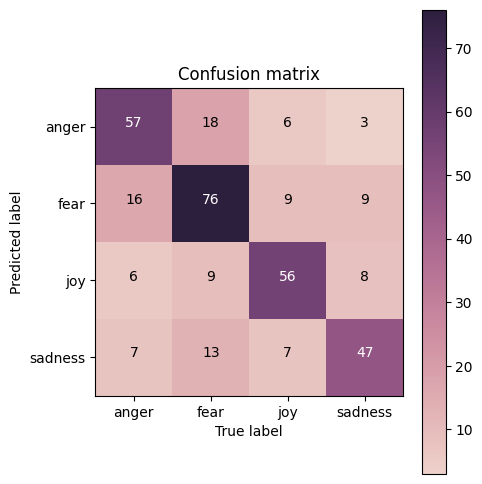

In [38]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

First, the model's precisions and recalls of all sentiments are approximately around 0.66. That indicates the model has uniform performance across all classes without a significant bias toward any particular category although the precision is not good. But I do have an interesting insight. we can see the correctly classified examples on the diagonal are proportional to the number of training examples of the 4 sentiments.

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results?

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [39]:
from sklearn.naive_bayes import MultinomialNB

NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)

## predict!
y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

Results

In [40]:
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print(f'training accuracy: {acc_train:.2f}')
print(f'testing accuracy: {acc_test:.2f}')

training accuracy: 0.79
testing accuracy: 0.70


In [41]:
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347



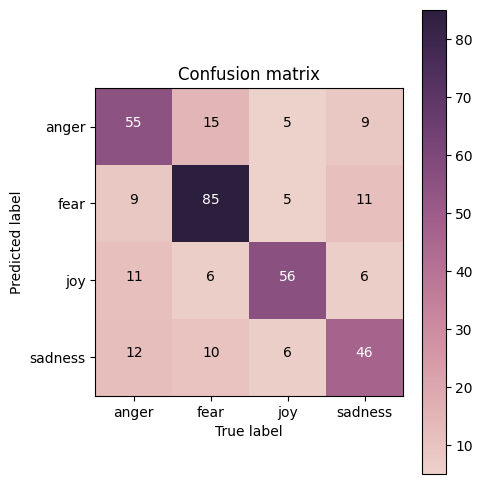

In [42]:
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

The Naive Bayes (NB) model outperforms the Decision Tree (DT) model. A difference between the NB model and the DT model is that it is more biased to high-frequency sentiments. Another difference is that DT model fits the training set better than the NB model does, but the former's evaluation result is worse than that of the latter. This indicates an overfit of the DT model.

---

## 5. Other things you can try

Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by:
- Trying different features (Feature engineering)e.g Word2Vec, PCA, LDA, FastText, Clustering
- Trying different models
- Analyzing your results and interpret them to improve your feature engineering/model building process
- Iterate through the steps above until finding a satisfying result

Remember that you should also consider the task at hand and the model you'll feed the data to.

---
## 6. Deep Learning

We use [Keras](https://keras.io/) to be our deep learning framework, and follow the [Model (functional API)](https://keras.io/models/model/) to build a Deep Neural Network (DNN) model. Keras runs with Tensorflow in the backend. It's a nice abstraction to start working with NN models.

Because Deep Learning is a 1-semester course, we can't talk about each detail about it in the lab session. Here, we only provide a simple template about how to build & run a DL model successfully. You can follow this template to design your model.

We will begin by building a fully connected network, which looks like this:

![pic1.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic1.png?raw=true)

(source: https://github.com/drewnoff/spark-notebook-ml-labs/tree/master/labs/DLFramework)


### 6.1 Prepare data (X, y)

In [43]:
import keras

# standardize name (X, y)
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 500)
y_train.shape:  (3613,)
X_test.shape:  (347, 500)
y_test.shape:  (347,)


In [44]:
import keras

In [45]:
BOW_500.transform(test_df['text'])

<347x500 sparse matrix of type '<class 'numpy.int64'>'
	with 4103 stored elements in Compressed Sparse Row format>

### 6.2 Deal with categorical label (y)

Rather than put your label `train_df['emotion']` directly into a model, we have to process these categorical (or say nominal) label by ourselves.

Here, we use the basic method [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) to transform our categorical  labels to numerical ones.


In [46]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 824     anger
1138     fear
44      anger
2759      joy
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


### 6.3 Build model

In [47]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  500
output_shape:  4


![pic2.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic2.png?raw=true)

In [48]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,484 (142.52 KB)

 Trainable params: 36,484 (142.52 KB)

 Non-trainable params: 0 (0.00 B)

### 6.4 Train

In [49]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25


c:\Users\james\anaconda3\envs\DataMining\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3245 - loss: 1.3650 - val_accuracy: 0.4294 - val_loss: 1.2974
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5996 - loss: 1.1087 - val_accuracy: 0.6715 - val_loss: 0.9488
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7879 - loss: 0.6294 - val_accuracy: 0.6974 - val_loss: 0.7898
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.4033 - val_accuracy: 0.7089 - val_loss: 0.7919
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8950 - loss: 0.3255 - val_accuracy: 0.6859 - val_loss: 0.8327
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9197 - loss: 0.2624 - val_accuracy: 0.6772 - val_loss: 0.9045
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9231 - loss: 0.2287 - val_accuracy: 0.7032 - val_loss: 0.9291
Epoch 8/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9408 - loss: 0.1893 - val_accuracy: 0.6888 - val_

### 6.5 Predict on testing data

In [50]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[9.1841048e-01, 4.3603107e-03, 7.4543230e-02, 2.6860039e-03],
       [2.9547673e-04, 9.8992330e-01, 9.4793029e-03, 3.0195457e-04],
       [1.2102745e-05, 1.3615478e-05, 5.3944268e-07, 9.9997377e-01],
       [1.9821562e-05, 9.9997592e-01, 2.6598154e-06, 1.5936101e-06],
       [9.9481446e-01, 1.4363735e-03, 4.0786592e-05, 3.7083507e-03]],
      dtype=float32)

In [51]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['anger', 'fear', 'sadness', 'fear', 'anger'], dtype=object)

In [52]:
from sklearn.metrics import accuracy_score

print(f'testing accuracy: {accuracy_score(label_decode(label_encoder, y_test), pred_result):.2f}')

testing accuracy: 0.68


In [53]:
#Let's take a look at the training log
training_log = pd.read_csv("training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.368115,1.334580,0.429395,1.297412
1,1,0.633269,1.013864,0.671470,0.948774
2,2,0.784113,0.599753,0.697406,0.789836
3,3,0.839469,0.434010,0.708934,0.791948
4,4,0.881816,0.337661,0.685879,0.832662
5,5,0.906449,0.278924,0.677233,0.904501
6,6,0.920288,0.232085,0.703170,0.929066
7,7,0.938002,0.194721,0.688761,0.971545
8,8,0.945198,0.170064,0.697406,1.044558
9,9,0.957653,0.141268,0.688761,1.074255


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?!

<table><tr>
    <td><img src="https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic3.png?raw=true" style="width: 300px;"/> </td>
    <td><img src="https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic4.png?raw=true" style="width: 300px;"/> </td>
</tr></table>

<Axes: >

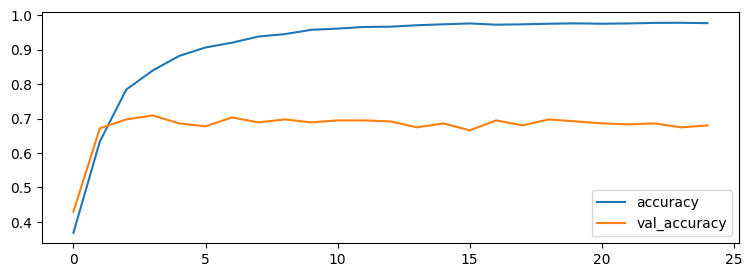

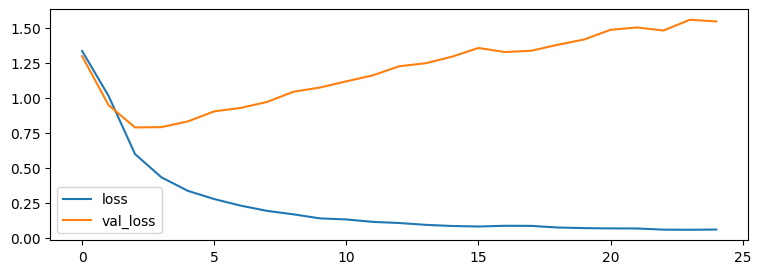

In [54]:
# Answer here
training_log[["accuracy", "val_accuracy"]].plot(figsize=[9,3])
training_log[["loss", "val_loss"]].plot(figsize=[9,3])

During the training process, both the training loss and training accuracy steadily improve. However, starting from the third epoch, the validation loss and accuracy begin to deviate from the trends observed in the training statistics. As more epochs pass, the gap between the training loss/accuracy and the validation loss/accuracy widens. These plots indicate signs of overfitting, where the model performs well on the training set but loses its generalizability.

---

### Note

If you don't have a GPU (level is higher than GTX 1060) or you are not good at setting lots of things about computer, we recommend you to use the [kaggle kernel](https://www.kaggle.com/kernels) to do deep learning model training. They have already installed all the librarys and provided free GPU for you to use.

Note however that you will only be able to run a kernel for 6 hours. After 6 hours of inactivity, your Kaggle kernel will shut down (meaning if your model takes more than 6 hours to train, you can't train it at once).


### More Information for your reference

* Keras document: https://keras.io/
* Keras GitHub example: https://github.com/keras-team/keras/tree/master/examples
* CS229: Machine Learning: http://cs229.stanford.edu/syllabus.html
* Deep Learning cheatsheet: https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning
* If you want to try TensorFlow or PyTorch: https://pytorch.org/tutorials/
https://www.tensorflow.org/tutorials/quickstart/beginner

---
## 7. Word2Vector

We will introduce how to use `gensim` to train your word2vec model and how to load a pre-trained model.

https://radimrehurek.com/gensim/index.html

### 7.1 Prepare training corpus

In [55]:
## check library
import gensim

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
824,10824,630am meeting Olympic House #10golds24 . #rel...,"[630am, meeting, Olympic, House, #, 10golds24,..."
1138,20281,Jesus wept! Another RNS from #rusty @metaltige...,"[Jesus, wept, !, Another, RNS, from, #, rusty,..."
44,10044,Why does @dapperlaughs have to come to Glasgow...,"[Why, does, @, dapperlaughs, have, to, come, t..."
2759,30755,"@rubeseatsinfo from here, it's but a short ste...","[@, rubeseatsinfo, from, here, ,, it, 's, but,..."
1199,20342,Onus is on #Pak to act against #terror groups ...,"[Onus, is, on, #, Pak, to, act, against, #, te..."


In [56]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['630am', 'meeting', 'Olympic', 'House', '#', '10golds24', '.', '#', 'relentless', '#', 'neverquit', '#', 'believe', '#', 'dreambig', '#', 'TeamTTO', '#', 'going4gold']),
       list(['Jesus', 'wept', '!', 'Another', 'RNS', 'from', '#', 'rusty', '@', 'metaltigerplc', 'quote', "'Price", 'sensitive', 'news', ',', 'Price', 'Sensitive', 'news', "'", 'etc', 'etc', 'The', '#', 'Ramping', 'here', 'is', '#', 'shocking']),
       list(['Why', 'does', '@', 'dapperlaughs', 'have', 'to', 'come', 'to', 'Glasgow', 'on', 'a', 'night', 'I', 'am', 'working', '.', 'I', 'am', 'fucking', 'gutted', ',', 'been', 'waiting', 'for', 'an', 'appearance', 'for', 'ages'])],
      dtype=object)

### 7.2 Training our model

You can try to train your own model. More details: https://radimrehurek.com/gensim/models/word2vec.html

In [57]:
from gensim.models import Word2Vec

## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus,
                          vector_size=vector_dim, window=window_size,
                          min_count=min_count, epochs=training_epochs)

![Imgur](https://i.imgur.com/Fca3MCs.png)

### 7.3 Generating word vector (embeddings)

In [58]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

array([ 0.78016955, -0.02417387, -0.2375909 ,  0.16305259, -0.5340705 ,
       -0.8281139 ,  0.83944887,  1.3162562 , -0.5442426 , -0.51544654,
       -0.7335099 , -1.0145613 , -0.71042114,  0.6331135 , -0.08317885,
       -0.43699345,  0.37303418, -0.4835765 ,  0.1189812 , -0.8500479 ,
        0.4330824 ,  0.97680825,  0.46374634,  0.09691622,  0.37094948,
        0.30228552, -0.7381991 ,  0.35635072, -0.5568628 , -0.24445756,
        0.06504852, -0.19456284,  0.46818236, -0.4053178 , -0.31498086,
        0.5372628 ,  0.46885   , -0.16335124, -0.25518247, -0.73718977,
       -0.08221436,  0.235293  , -0.05756044,  0.64662385,  0.5705027 ,
        0.00729712, -0.69380575, -0.18130787,  0.3302177 ,  0.40469033,
       -0.5005417 , -0.36814684,  0.3134197 , -0.32163408, -0.31264675,
       -0.5478097 ,  0.205181  , -0.4696206 , -0.35643783,  0.0874889 ,
       -0.14689781, -0.07542122,  0.3362209 , -0.07452483, -0.56287336,
        0.33385876, -0.23430978,  0.78296834, -1.4254339 ,  0.33

In [59]:
# Get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

[("'be", 0.907878041267395),
 ("'you", 0.8963430523872375),
 ('help', 0.8960548043251038),
 ('nuclear', 0.8957209587097168),
 ('Be', 0.8937594294548035),
 ('plz', 0.8926194906234741),
 ('Halifax', 0.8914791345596313),
 ('bday', 0.8905237913131714),
 ('trusted', 0.8891114592552185),
 ('cant', 0.8864358067512512)]

### 7.4 Using a pre-trained w2v model

Instead of training your own model ,you can use a model that has already been trained. Here, we see 2 ways of doing that:


#### (1) Download model by yourself

source: [GoogleNews-vectors-negative300](https://code.google.com/archive/p/word2vec/)

more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [60]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = f"{didiersalazar_google_news_vectors_path}/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

load ok


[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

#### (2) Using gensim api

Other pretrained models are available here: https://github.com/RaRe-Technologies/gensim-data

In [61]:
import gensim.downloader as api

## If you see `SSL: CERTIFICATE_VERIFY_FAILED` error, use this:
import ssl
import urllib.request
ssl._create_default_https_context = ssl._create_unverified_context

glove_twitter_25_model = api.load("glove-twitter-25")
print('load ok')

glove_twitter_25_model.most_similar('happy', topn=10)

load ok


[('birthday', 0.9577818512916565),
 ('thank', 0.937666654586792),
 ('welcome', 0.93361496925354),
 ('love', 0.9176183342933655),
 ('miss', 0.9164500832557678),
 ('hello', 0.9158351421356201),
 ('thanks', 0.915008544921875),
 ('merry', 0.9053249359130859),
 ('bless', 0.902732253074646),
 ('wish', 0.9013164043426514)]

### 7.5 king + woman - man = ?

Let's run one of the most famous examples for Word2Vec and compute the similarity between these 3 words:

In [62]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence).
How can we utilize these "word" vectors to represent the sentence data and train our model?


Since the embedded vectors carry the semantic meanings of corresponding words, we can add the vectors together, similar to combining the meanings of words. However, there are variations in how we can perform this addition.

1. Uniform average.
2. Weighted average by importants of words. TF-IDF can show importants.


## 8. Clustering: k-means

Here we introduce how to use `sklearn` to do the basic **unsupervised learning** approach, k-means.    

more details: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


#### Basic concept

![Image](https://i.imgur.com/PEdUf54.png)

(img source: https://towardsdatascience.com/k-means-clustering-identifying-f-r-i-e-n-d-s-in-the-world-of-strangers-695537505d)

In [63]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

target words:  ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']


In [64]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

word: happy 	 cluster: 0
word: fear 	 cluster: 0
word: angry 	 cluster: 0
word: car 	 cluster: 1
word: teacher 	 cluster: 1
word: computer 	 cluster: 1


![pic6.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic6.png?raw=true)

In [65]:
#check cluster membership
word = 'student'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([1])

In [66]:
#check cluster membership
word = 'sad'
word_vec = word2vec_model.wv[word]
kmeans_model.predict([word_vec])

array([0])


## 9. High-dimension Visualization: t-SNE and UMAP

No matter if you use the Bag-of-words, TF-IDF, or Word2Vec, it's very hard to see the embedding result, because the dimension is larger than 3.  

In Lab 1, we already talked about PCA, t-SNE and UMAP. We can use PCA to reduce the dimension of our data, then visualize it. However, if you dig deeper into the result, you'd find it is insufficient.

Our aim will be to create a visualization similar to the one below with t-SNE:

![pic7.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic7.png?raw=true)
source: https://www.fabian-keller.de/research/high-dimensional-data-visualization

And also like this for UMAP:

![pic9.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic9.png?raw=true)

source: https://umap-learn.readthedocs.io/en/latest/auto_examples/plot_mnist_example.html

t-SNE and UMAP reference:  
http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
https://umap-learn.readthedocs.io/en/latest/

### 9.1 Prepare visualizing target

Let's prepare data lists like:
- happy words
- angry words
- data words
- mining words

In [67]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed']
data_words:  ['data', 'Data', 'datasets', 'dataset', 'databases', 'statistics']
mining_words:  ['mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'data', 'Data', 'datasets', 'dataset', 'databases', 'statistics', 'mining', 'Mining', 'mines', 'coal_mining', 'mine', 'miner']

color list:
['b', 'b', 'b', 'b', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'r', 'r', 'r', 'r', 'r', 'r', 'y', 'y', 'y', 'y', 'y', 'y']


### 9.2 Plot using t-SNE and UMAP (2-dimension)

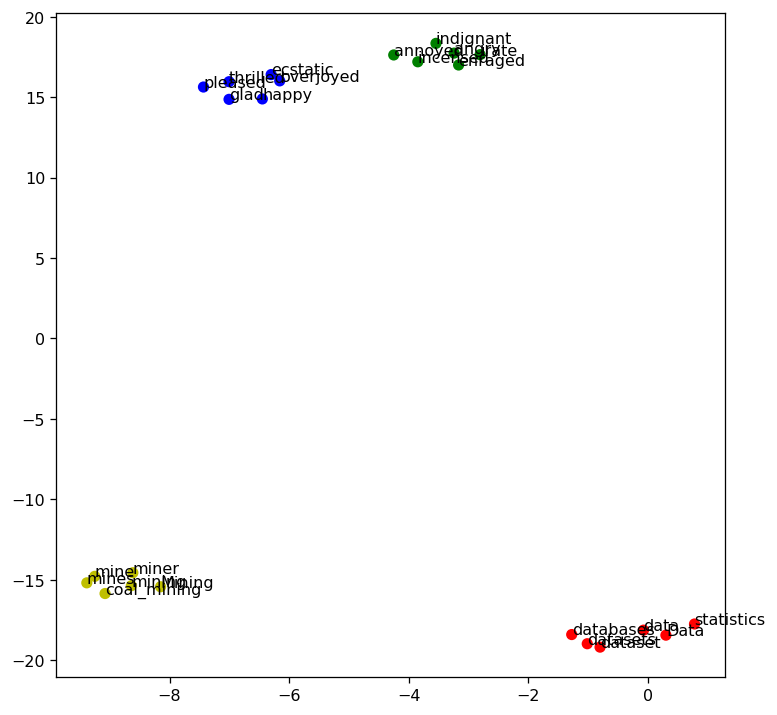

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

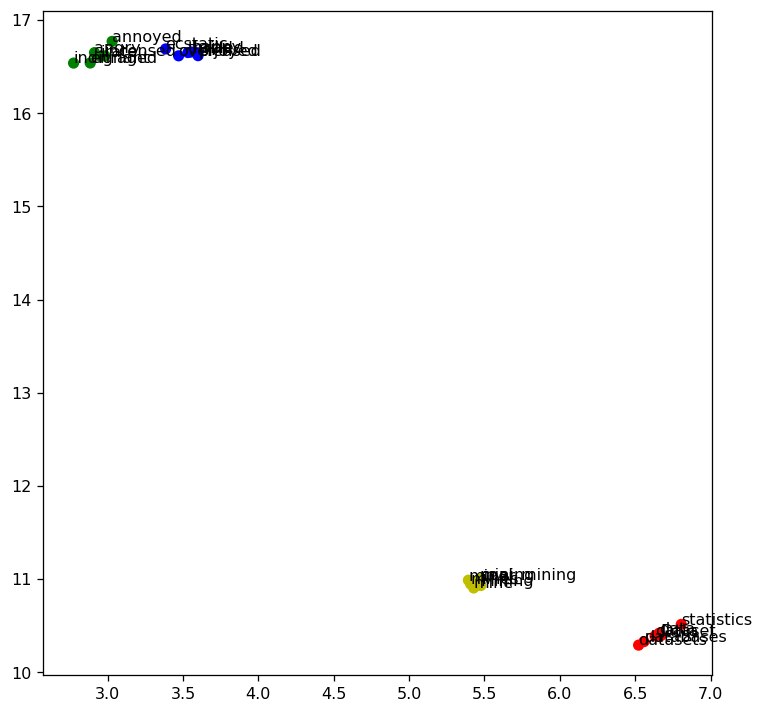

In [69]:
import matplotlib.pyplot as plt
import umap.umap_ as umap

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## UMAP model
umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=28)

## training
X_umap = umap_model.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_umap[:target_size, 0], X_umap[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_umap[:target_size, 0], X_umap[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()



### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE and UMAP visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total). Compare the differences between both graphs.

In [70]:
word_list = ['angry', 'happy', 'sad', 'fear']

topn = 15
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]

print('angry_words: ', angry_words)
print('happy_words: ', happy_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = angry_words + happy_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'e

#### t-SNE

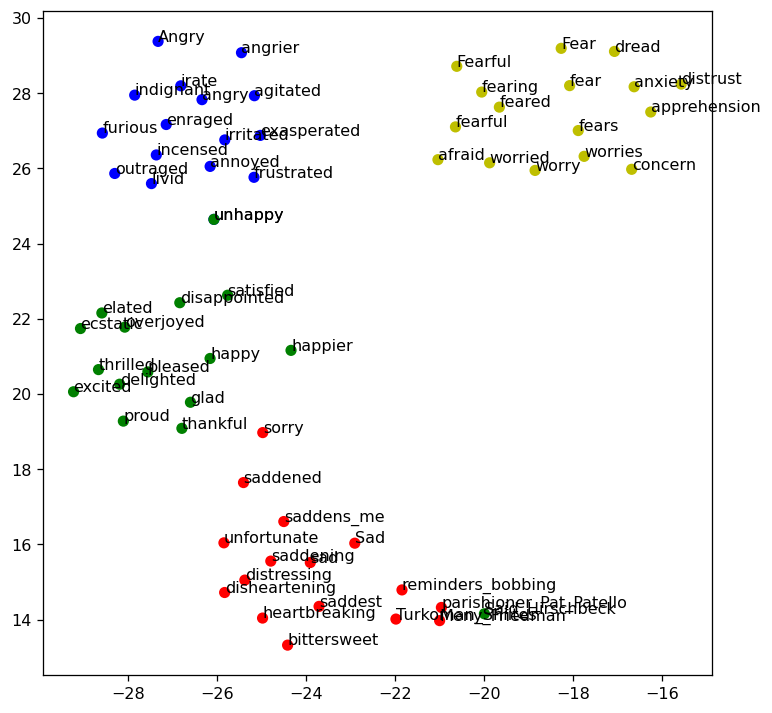

In [71]:
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 600
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

#### UMAP

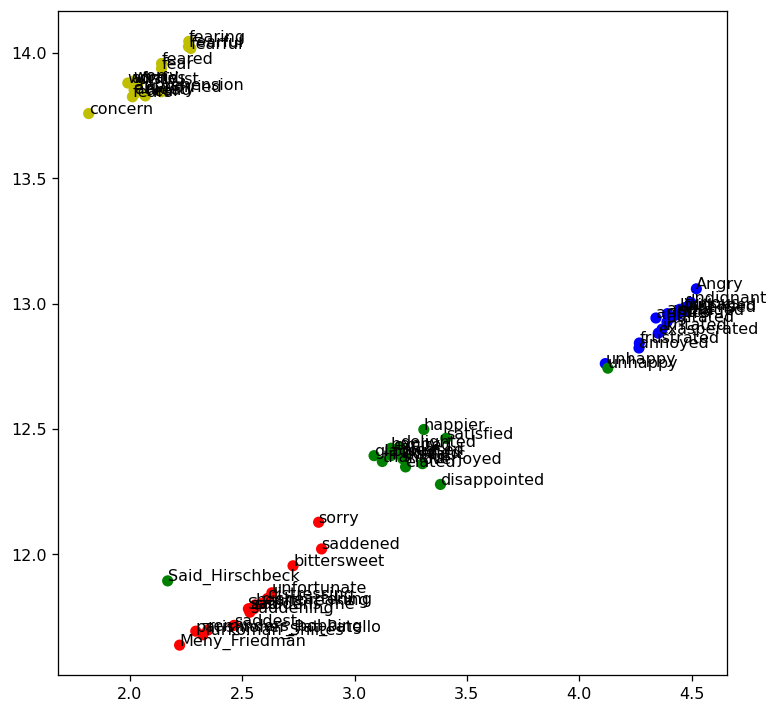

In [72]:
## w2v model
model = w2v_google_model

## prepare training word vectors
size = 600
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## UMAP model
umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=28)

## training
X_umap = umap_model.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_umap[:target_size, 0], X_umap[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_umap[:target_size, 0], X_umap[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

The clusters in the t-SNE plot are sparser than those in the UMAP plot, and each cluster in the t-SNE plot is closer to the others, unlike the distribution in the UMAP plot. In conclusion, the inter- and intra-relationships of points in the t-SNE plot make clustering tasks more difficult compared to the UMAP plot.

## 10. Large Language Models (LLMs)
Large Language Models (LLMs) are AI models trained on vast text data to understand and generate human language. Models like GPT and BERT excel at tasks like translation, summarization, and sentiment analysis due to their deep learning techniques and large-scale training. Recently these models got popular with the rise of Open-AI's ChatGPT and their different models, showcasing the potential of these models in a lot of aspects of our current society.

Open-source LLMs are cost-effective and customizable, with strong community support, but may underperform compared to paid models and require technical expertise to manage. Paid LLMs offer superior performance, ease of use, and regular updates, but are costly, less flexible, and create dependency on external providers for ongoing access and updates.

#### Open Source LLMs:
In this lab we are going to use Ollama ([Ollama GitHub Link](https://github.com/ollama/ollama)), that is a library that let us use a long list of open-source LLMs of differing size. For this section we are going to be using **'llama3.2'** or **'llama3.2:1b'** for **text based tasks**, and **'llava-phi3'** for **multi-modal tasks** (e.g. image to text). Ollama has a great variety of models, and those can be found here: [model library](https://ollama.com/library). You are free to explore them if you want to try using them, you can check the advantages and disadvantages of each.

Or they can also be observed in here:

![pic10.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic10.png?raw=true)


In the previous image we can observe that all LLMs have something called parameters, these are the internal weights that the model learns during training, helping it understand and generate language. The more a model has, the more complex and accurate it can be, but it also needs more memory to run.

For example:

Models with **7 billion parameters** need at least **8 GB of VRAM**.
**13 billion parameters** require **16 GB of VRAM**.
**33 billion parameters** need **32 GB of VRAM**.
The higher the number of parameters, the more memory and computational power the model needs to function efficiently.

And so that is why we are trying to use small LLMs for this practice, because they require a lot of computational resources, so by using 'llama3.2' and 'llava-phi3', both models with 3 billion parameters, we will only use at most 8 GB of VRAM. But if there are some issues with 'llama3.2' we can still use 'llama3.2:1b' the model with 1 billion parameters that requires less resources.

So now let's talk about the models:
**LLaMA 3.2** is part of the LLaMA series (Large Language Model Meta AI), designed to provide efficient language understanding and generation. Despite having fewer parameters than some larger models, it offers strong performance in NLP tasks, making it suitable for scenarios where both accuracy and resource efficiency are important.

**LLaVA** (Large Language and Vision Assistant) models, like **LLaVA-Phi3** are multimodal models combining language and vision capabilities. It can interpret visual inputs like images and generate corresponding text, making it ideal for tasks that require both visual understanding and language generation, such as image captioning and answering visual-based questions.

**I will be using the llama3.2 model going onwards, you can change it for the smallest version if it is necessary for you, or you can try to run it on Kaggle where you can use online GPU resources for it.**

### 10.1 Text Prompting
Like with ChatGPT we can use these models to ask about anything. Here we are going to ask a question and then ask it to return it in markdown format to make it look better afterwards.

In [73]:
import ollama

In [ ]:
response = ollama.chat(model='llama3.2', messages=[
    {
        'role': 'user',
        'content': 'What is data mining? (in markdown format)'
    },
])

print(response['message']['content'])

**Data Mining**

**Definition**: Data mining is the process of automatically discovering patterns, relationships, and insights from large datasets.

### **Process**

1. **Data Collection**: Gathering relevant data from various sources.
2. **Data Preprocessing**: Cleaning, transforming, and preparing data for analysis.
3. **Data Analysis**: Applying algorithms and statistical techniques to discover patterns and relationships.
4. **Pattern Evaluation**: Assessing the quality and relevance of discovered patterns.

### **Types**

*   **Supervised Learning**: Predicting a target variable based on observed data.
*   **Unsupervised Learning**: Identifying patterns or structure in data without a target variable.
*   **Semi-Supervised Learning**: Combining supervised and unsupervised learning techniques.

### **Applications**

*   **Marketing**: Customer segmentation, predicting churn, recommending products
*   **Finance**: Credit risk assessment, portfolio optimization, detecting anomalies
*  

**We can use the IPython library to make the response look better:**

In [41]:
from IPython.display import display, Markdown, Latex
display(Markdown('*some markdown* $\phi$'))

*some markdown* $\phi$

In [42]:
display(Markdown(response['message']['content']))

**Data Mining**
================

### Definition

Data mining is the process of automatically discovering patterns, relationships, and insights from large datasets using various algorithms and statistical techniques.

### Overview

Data mining involves the use of various tools and techniques to extract valuable knowledge from existing data. It can be used for a variety of purposes, including:

* **Predictive analytics**: predicting future events or behaviors based on past data.
* **Customer segmentation**: identifying groups of customers with similar characteristics.
* **Marketing analysis**: analyzing customer behavior to improve marketing strategies.
* **Quality control**: monitoring and controlling the quality of products or services.

### Process

The data mining process typically involves the following steps:

1. **Problem definition**: defining a problem or question that needs to be answered through data mining.
2. **Data collection**: gathering relevant data from various sources, such as databases, files, or online repositories.
3. **Data preprocessing**: cleaning and preparing the data for analysis.
4. **Data modeling**: creating mathematical models to describe patterns and relationships in the data.
5. **Pattern identification**: identifying interesting patterns and insights in the data using algorithms and statistical techniques.
6. **Evaluation**: evaluating the accuracy and relevance of the discovered patterns and insights.
7. **Deployment**: deploying the discovered knowledge into a real-world application.

### Techniques

Some common data mining techniques include:

* **Supervised learning**: using labeled data to train models that make predictions on new, unseen data.
* **Unsupervised learning**: using unlabeled data to identify patterns and relationships in the data.
* **Clustering**: grouping similar data points into clusters based on their characteristics.
* **Decision trees**: using tree-like models to classify data or make predictions.

### Tools

Some common tools used for data mining include:

* **R**
* **Python** (with libraries such as Pandas, NumPy, and scikit-learn)
* **SQL**
* **Data visualization tools** (such as Tableau or Power BI)

### Applications

Data mining has a wide range of applications in various fields, including:

* **Business**: customer segmentation, market analysis, predictive analytics.
* **Healthcare**: disease diagnosis, patient outcomes, personalized medicine.
* **Finance**: risk management, portfolio optimization, credit scoring.
* **Social media**: sentiment analysis, social network analysis.


### ** >>> Exercise 9 (Take home): **  

You noticed there is a **role** parameter inside the ollama.chat function, investigate what other roles there can be inside the function and what do they do. Give an example of a prompt using another role in additional to the **user** one.

The role field in a converation denotes the a specific position. It can be either `system`, `user`, `assistant`, or `tool`. The `user` is the input of us users. The `assistant` is the response of the LLM. The `system` is a field where basic behaviors or roles of the LLM is defined. The `tool` field is an extension that allow LLMs to access functionalities like calculators, searching engines, or external API, which boarden the ability of LLMs.

Below is an example combining the use of `system`, `user`, and `assistant` fields. I use `system` to define the format of output, use `user` to input the question, and use the `assistant` field to implement CoT (chain-of-thought).

In [ ]:
# Answer here
CoT_prompt = "### Reasoning\nLet's break down this question"

response = ollama.chat(
    model="llama3.2",
    messages=[
        {"role": "system", "content": "Respond in markdown format."},
        {
            "role": "user",
            "content": "Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",
        },
        {"role": "assistant", "content": CoT_prompt},
    ],
)

display(Markdown(CoT_prompt + response["message"]["content"]))

### Reasoning
Let's break down this question step by step.

### Given Information

*   Wallet price: $100
*   Betty has only half of the needed amount: 50% of 100 = $50
*   Parents gave her: $15
*   Grandparents gave her twice as much as parents: 2 x $15 = $30

### Calculating Total Amount Received
Total money received from parents and grandparents: $15 + $30 = $45

### Calculating Remaining Amount Needed
Remaining amount needed to buy the wallet:
$100 (wallet price) - $50 (amount Betty has) - $45 (total amount received) 
= $5 

Therefore, Betty needs 5 more dollars to buy the wallet.

### 10.2 Multi-Modal Prompting - Text + Images
Multi-modal prompting involves using input from multiple sources or modes, such as text, images, or audio, to guide a model's response. It allows AI to process and generate information based on more than one type of input.

For image plus text prompting, the model receives both an image and a related text prompt. The image provides visual context, while the text gives additional guidance. The model uses both inputs to generate more accurate and contextually relevant responses, which is useful for tasks like image captioning, visual question answering, or content generation based on visual cues.

Let's look at the following images that are in the **pics** folder in the directory of this notebook:

![example1.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/example1.png?raw=true)

source: https://cooljapan-videos.com/tw/articles/epe0y86g

![example2.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/example2.jpg?raw=true)

source: https://www.istockphoto.com/photo/young-cat-scottish-straight-gm1098182434-294927481

We will use the **llava-phi3** model that we installed to request a description of the images:

In [52]:
import ollama
response2 = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': [f'{didiersalazar_pictures_path}/pics/example1.png'] #Image with the dog
    },
])

display(Markdown(response2['message']['content']))

In the center of a vibrant, grassy lawn, a small dog with orange and white fur is captured in mid-air. The dog's body is stretched out horizontally, its front legs extended forward and hind legs backward, as if it has just launched itself into flight. Its tail is curled upwards, adding to the sense of motion. The dog's mouth is wide open, perhaps yawning or simply reveling in the joy of running across the lawn.

The background behind the dog is blurred and indistinct, suggesting that it's not as important as the main subject - our airborne canine friend. However, one can make out what appear to be trees and a fence, providing context for the setting. The image exudes a sense of playful energy and freedom, with the dog appearing to defy gravity on its grassy runway.

In [53]:
response3 = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': [f'{didiersalazar_pictures_path}/pics/example2.jpg'] #Image with the cat
    },
])

display(Markdown(response3['message']['content']))

In the center of a white background, a gray tabby cat with black stripes stands on its hind legs. The cat's body is facing towards the right side of the frame, while its tail is curved upwards. Its ears are perked forward and it gazes directly at the camera, giving off a curious expression. The cat appears alert and engaged in its surroundings. Despite being alone in the image, the cat seems to be waiting or observing something that's not visible in the frame. There are no other objects present in the image.


### ** >>> Exercise 10 (Take home): **  

Try asking the model with one image of your choosing. Is the description accurate? Why?

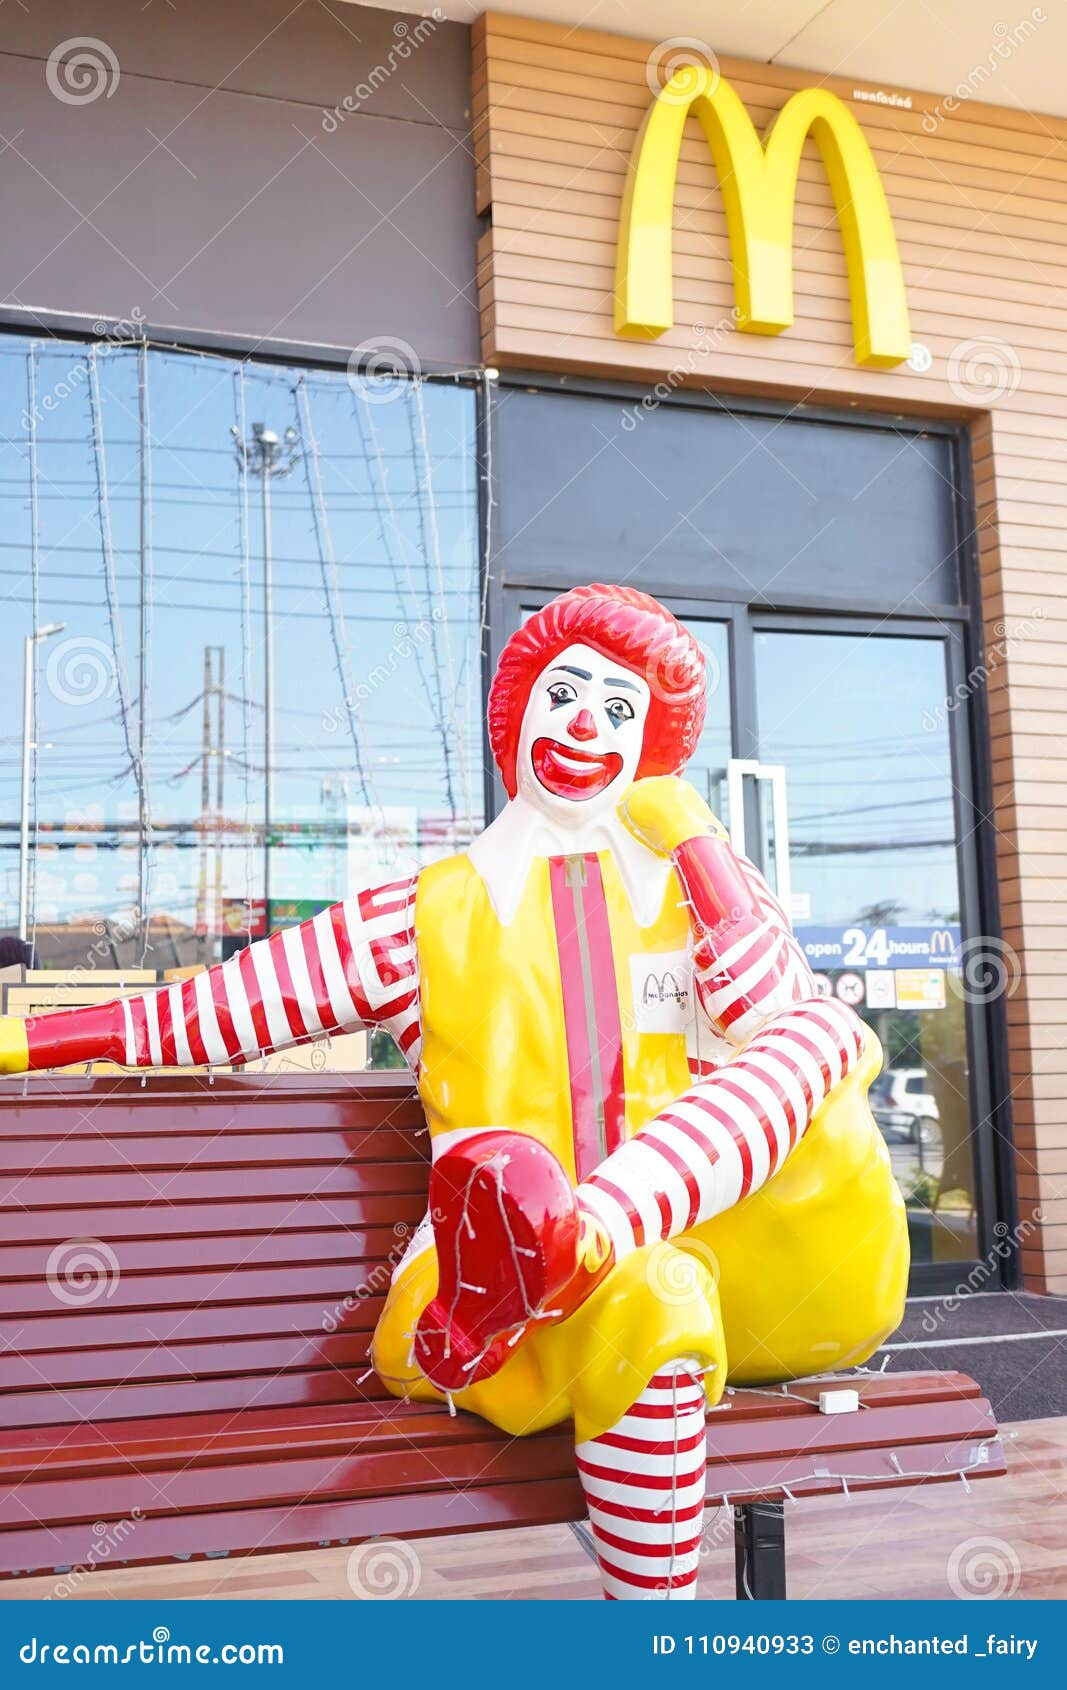

In [ ]:
import requests
from IPython.display import Image, display

response = requests.get("https://thumbs.dreamstime.com/z/chonburi-thailand-december-portrait-photo-ronald-mcdonald-clown-character-mascot-mcdonald-s-sitting-bench-110940933.jpg")
with open("temp.jpg", "wb") as file:
        file.write(response.content)

display(Image('temp.jpg'))

In [67]:
response3 = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': ['temp.jpg']
    },
])

display(Markdown(response3['message']['content']))

The image features a vibrant Ronald McDonald statue, the iconic mascot of the fast-food chain Mcdonald's. The statue is seated on a red bench with its legs crossed and arms resting on its knees, exuding an air of casual relaxation that aligns with the brand's image. It's dressed in a bright yellow vest over a white shirt, and sports classic Ronald McDonald colors - a red clown nose and blue eyes.

The statue is set against the backdrop of a McDonald's restaurant storefront. The golden arches of the Mcdonald's logo are prominently displayed above the entrance, reinforcing brand identity. Power lines can be seen in the background, suggesting an urban setting for the location. A car is parked on the street adjacent to the restaurant, adding a touch of everyday life to the scene.

The image captures not just Ronald McDonald, but also gives us a glimpse into his surroundings and how he's integrated into them. It's more than just an advertisement; it's a snapshot of brand presence in real-world context.

This description is almost correct. The model successfully identified the character in the middle of the image, the pose, and the background of it. Some minor mistake like "blue eyes" which does not show up in the image is just some trivial and common hallucination of language models. The most astonishing point is that the model even noticed the reflection of a car on the front door.

### 10.3 Retrieval-Augmented Generation (RAG)
RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (e.g., Llama3.2). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

In [ ]:
import ollama
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

llm_model = "llama3.2" #You can change to the one of your preference

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict()
    )
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = OllamaEmbeddings(model=llm_model) #Generating embeddings with our chosen model
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()

url="https://www.ibm.com/topics/large-language-models"
# Create the retriever
retriever = load_and_retrieve_docs(url)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='llama3.2', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context)

# Use the RAG chain
result = rag_chain("What are the related solutions of IBM with LLMs?")
display(Markdown(result))

IBM has several related solutions with LLMs (Large Language Models), including:

1. Watson Assistant: A cloud-based conversational AI platform that uses IBM's Granite model series as its generative AI backbone.
2. Watson Orchestrate: A workflow automation and integration platform that leverages IBM's Granite model series to generate text and responses.
3. watsonx.ai: An AI development platform that provides access to IBM's Granite model series, which serves as the generative AI backbone for various IBM products.

These solutions showcase IBM's investment in LLMs and their application in various business functions and use cases, including natural language understanding (NLU) and natural language processing (NLP).


### **Actual content in the URL:**
![pic11.png](https://github.com/didiersalazar/DM2024-Lab2-Master/blob/main/pics/pic11.png?raw=true)

source: https://www.ibm.com/topics/large-language-models


### ** >>> Exercise 11 (Take home): **  

Try to modify the code to make it accept **three URLs**, or **three text documents** of your choosing. After modifying it, make **three prompts/questions** with information that can be found in each of the documents/urls, **compare the accuracy of the response** with the actual answer. Investigate and discuss the advantages and disadvantages of RAG systems.

In [ ]:
import ollama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

llm_model = "llama3.2"  # You can change to the one of your preference

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(urls: list[str]):
    loader = WebBaseLoader(urls)
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)
    embeddings = OllamaEmbeddings(model=llm_model)
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)
    return vectorstore.as_retriever()

urls = [
    "https://www.ibm.com/topics/large-language-models",
    "https://docs.smith.langchain.com/",
    "https://en.wikipedia.org/wiki/Riemann_hypothesis",
]
# Create the retriever
retriever = load_and_retrieve_docs(urls)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(
        model="llama3.2", messages=[{"role": "user", "content": formatted_prompt}]
    )
    return response["message"]["content"]

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context)

# Use the RAG chain
result = rag_chain("What are the related solutions of IBM with LLMs?")
display(Markdown(result))

IBM has developed several solutions related to Large Language Models (LLMs), including:

1. Watson Assistant: a cloud-based AI service that uses LLMs to power conversational interfaces.
2. Watson Orchestrate: a workflow management platform that leverages LLMs for text analysis and generation.
3. Granite model series on watsonx.ai: a generative AI backbone for other IBM products, which has become the standard for generating human-like text.

These solutions showcase IBM's investment in LLMs and their applications in natural language understanding (NLU) and natural language processing (NLP).

In [81]:
result = rag_chain("What can Lang Smith do?")
display(Markdown(result))

According to the text, Lang Smith can generate content in accessible formats, specifically:

* Assisting individuals with disabilities through text-to-speech applications
* Generating content in accessible formats

However, it does not explicitly mention Lang Smith as a person who can perform these tasks. The text seems to refer to LLMs (Large Language Models) and their capabilities, rather than a specific individual named Lang Smith.

In [79]:
result = rag_chain("How can the Riemann hypothesis be generalized")
display(Markdown(result))

The Riemann Hypothesis (RH) is a fundamental problem in number theory that deals with the distribution of prime numbers. It has been open for over 150 years, and its resolution has significant implications for many areas of mathematics and computer science.

Generalizing the Riemann Hypothesis:

1. **Modular forms**: The RH can be generalized to modular forms, which are functions on the upper half-plane that satisfy certain transformation properties under Möbius transformations.
2. **L-functions**: The RH can also be generalized to L-functions, which are associated with arithmetic functions and have a similar distribution theory as the zeta function.
3. **Dirichlet series**: The RH can be generalized to Dirichlet series, which are formal power series that satisfy certain properties related to prime numbers.
4. **Covariant L-functions**: The RH can also be generalized to covariant L-functions, which are functions on the upper half-plane that satisfy a similar transformation property as modular forms.

Some open problems and conjectures in number theory that relate to the Riemann Hypothesis include:

1. **The Birch and Swinnerton-Dyer Conjecture**: This conjecture relates to the arithmetic of elliptic curves and has connections to the RH.
2. **The Modularity Theorem**: This theorem states that every elliptic curve over the rational numbers can be represented by a modular form, which is closely related to the RH.
3. **The Sato-Tate Conjecture**: This conjecture relates to the distribution of prime numbers in arithmetic progressions and has connections to the RH.

Research directions:

1. **Computational verification**: Researchers are exploring ways to computationally verify the Riemann Hypothesis, which could lead to a proof or disproof.
2. **Approximation methods**: Methods such as approximation theory and complex analysis can be used to study the distribution of prime numbers and develop new tools for number theory.
3. ** Connections to other areas**: Researchers are investigating connections between the RH and other areas of mathematics, such as algebraic geometry, representation theory, and quantum mechanics.

Some notable open problems in number theory that relate to the Riemann Hypothesis include:

1. **The Twin Prime Conjecture**: This conjecture states that there are infinitely many pairs of primes that differ by 2.
2. **The Goldbach Conjecture**: This conjecture states that every even integer greater than 2 can be expressed as the sum of two prime numbers.
3. **The Prime Number Theorem for arithmetic progressions**: This conjecture states that the distribution of prime numbers in arithmetic progressions follows a certain law.

Overall, the Riemann Hypothesis is an open problem that has far-reaching implications for number theory and mathematics. Researchers are exploring new directions and tools to study this problem, which could lead to breakthroughs in many areas of mathematics.

#### Analysis

The third response is comprehensive. In fact, it is too extensive and fluent to tell whether it is based on the model's own knowledge or the augmentation provided by RAG. The first (IBM) and the second (LangSmith) responses show that the model did receive some segments of the documents and then generated responses according to the documents. However, in the second example, the model's response is purely a paraphrase, without knowing what LangSmith is. This is a sign of a drawback of RAG: the model only received partial information, lacking backgrounds and contexts. Nevertheless, RAG is a simple and effective method to enhance the model's knowledge base.

### 10.4 Generating LLM Embeddings:
LLM embeddings are dense vector representations of text generated by Large Language Models. These embeddings, like we have already seen in the lab, capture the semantic meaning and relationships between words, phrases, or even entire documents by mapping them into a high-dimensional space where similar pieces of text are placed closer together. What makes LLM embeddings special is that they are contextual and rich in meaning, meaning the same word can have different embeddings based on its surrounding context.

For example, the word **"bank"** would have different embeddings in the sentences **"I sat by the river bank"** and **"I deposited money in the bank."** This ability to understand and encode context enables LLM embeddings to outperform traditional techniques (like TF-IDF or one-hot encoding) by providing a deeper, more nuanced representation of language.

Additionally, LLM embeddings are pre-trained on vast amounts of data, allowing them to generalize well across different tasks (like classification, clustering, or similarity detection) without the need for extensive retraining. This makes them highly valuable in many natural language processing tasks today.

**Now let's generate some embeddings with llama 3.2 for our dataset:**

In [77]:
import pandas as pd
from ollama import Client

# Let's copy our dataframes for training and testing
df_train = train_df
df_test = test_df


# Define a function to generate embeddings
client = Client(host='http://192.168.0.198:11434')
def generate_embeddings(row, text_column_name="text"):
    embeddings = client.embeddings(
        model="llama3.2",
        prompt=row[text_column_name],
    )
    return embeddings["embedding"]

In [78]:
# We use the text column
column_name = 'text'

# Apply the function to the specified column and store the result in a new column 'embeddings'
df_train['embeddings'] = df_train.apply(lambda row: generate_embeddings(row, column_name), axis=1)
df_test['embeddings'] = df_test.apply(lambda row: generate_embeddings(row, column_name), axis=1)

In [79]:
df_train #We can see the new column with the embeddings

,id,text,emotion,intensity,text_tokenized,embeddings
824,10824,630am meeting Olympic House #10golds24 . #rel...,anger,0.208,"[630am, meeting, Olympic, House, #, 10golds24,...","[-0.6259795427322388, 0.931820809841156, 3.364..."
1138,20281,Jesus wept! Another RNS from #rusty @metaltige...,fear,0.637,"[Jesus, wept, !, Another, RNS, from, #, rusty,...","[-0.6142764687538147, -0.09002596884965897, 3...."
44,10044,Why does @dapperlaughs have to come to Glasgow...,anger,0.733,"[Why, does, @, dapperlaughs, have, to, come, t...","[-0.7967213988304138, -1.2549934387207031, 0.5..."
2759,30755,"@rubeseatsinfo from here, it's but a short ste...",joy,0.208,"[@, rubeseatsinfo, from, here, ,, it, 's, but,...","[0.8061891794204712, 0.04565060883760452, 5.31..."
1199,20342,Onus is on #Pak to act against #terror groups ...,fear,0.604,"[Onus, is, on, #, Pak, to, act, against, #, te...","[0.07561430335044861, -0.5983462333679199, 0.0..."
...,...,...,...,...,...,...
2667,30663,HMS Pinafore' time.\n\nI need some mirth.,joy,0.312,"[HMS, Pinafore, ', time.\n\nI, need, some, mir...","[0.3132394850254059, -1.25997793674469, -2.162..."
280,10280,the outrage has passed and has been replaced b...,anger,0.562,"[the, outrage, has, passed, and, has, been, re...","[-0.8843216300010681, 0.3258392810821533, -1.5..."
320,10320,@NM_NickNocturne Incentivise people to roam th...,anger,0.542,"[@, NM_NickNocturne, Incentivise, people, to, ...","[-1.5133851766586304, 0.9024900794029236, -0.2..."
3575,40748,@VaunWilmott @PrisonBreak @PBWritersRoom linc ...,sadness,0.208,"[@, VaunWilmott, @, PrisonBreak, @, PBWritersR...","[0.5465880036354065, 0.7293986678123474, 4.891..."


In [80]:
df_test #We can see the new column with the embeddings

,id,text,emotion,intensity,embeddings
43,10900,"Kik to trade, have fun or a conversation (kik...",anger,0.167,"[-0.3645806312561035, -0.2668246328830719, 3.3..."
127,21190,Watching It Follows. This is a super freaky m...,fear,0.708,"[0.6026381254196167, 1.0684852600097656, -0.27..."
284,40797,Wow just watched Me Before You and it was seri...,sadness,0.667,"[-0.6668939590454102, 1.5726101398468018, 1.28..."
181,21244,Not the best horror ever but I like that the u...,fear,0.333,"[-1.3656611442565918, -0.89332515001297, 2.094..."
295,40808,If Angelina Jolie can't keep a man no one can....,sadness,0.646,"[-1.6493831872940063, 0.25768622756004333, 3.2..."
...,...,...,...,...,...
107,21170,The Apocalypse has hit our gym and it's nothi...,fear,0.583,"[-0.7601320147514343, 0.07843855023384094, 1.0..."
334,40847,Chalk dance notation entree manchester inasmuc...,sadness,0.188,"[1.4790529012680054, -0.7231601476669312, 1.82..."
273,40786,@1johndes ball watching &amp; Rojo'd header wa...,sadness,0.583,"[-0.44519591331481934, 0.689314603805542, -3.1..."
256,30885,@MacDsmash you should get some @SSB_Swedish de...,joy,0.404,"[-0.7138317227363586, -0.5931963324546814, 5.7..."


In [101]:
len(df_test.embeddings[0])

3072

Now let's train some models with these embeddings:

**KNeighborsClassifier (KNN)**: KNN is a simple, instance-based machine learning algorithm used for classification. It works by finding the 'k' nearest neighbors to a data point based on a distance metric (e.g., Euclidean distance) and assigning the most common class among those neighbors to the data point. KNN is non-parametric, meaning it doesn’t assume a specific form for the underlying data distribution, and it classifies points based on their similarity to other points in the training set. It's easy to understand and implement, though it can become computationally expensive with large datasets.

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Let's use the new Llama 3.2 embeddings as our training features and the emotions as our labels
X_train = df_train["embeddings"].tolist()
y_train = df_train["emotion"]

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [82]:
len(df_train["embeddings"][0]) # Llama 3.2 embedding dimension is 3072

3072

In [83]:
X_test = df_test["embeddings"].tolist()
y_test = df_test["emotion"]

# Predicting the label for the test data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN Accuracy: {accuracy}")

KNN Accuracy: 0.45821325648414984


In [84]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

       anger       0.40      0.45      0.42        84
        fear       0.53      0.55      0.54       110
         joy       0.43      0.41      0.42        79
     sadness       0.45      0.39      0.42        74

    accuracy                           0.46       347
   macro avg       0.45      0.45      0.45       347
weighted avg       0.46      0.46      0.46       347



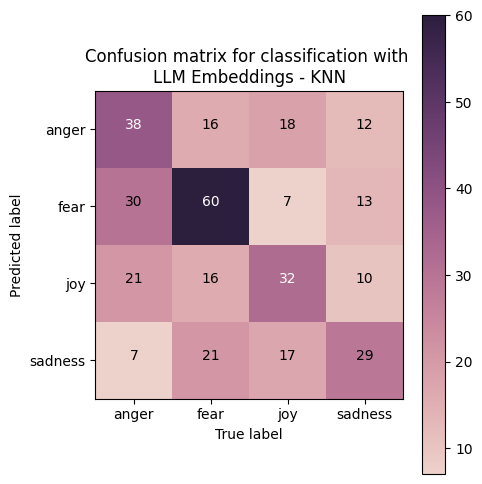

In [85]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(y_true=y_test, y_pred=y_pred)
my_tags = ["anger", "fear", "joy", "sadness"]
plot_confusion_matrix(
    cm2,
    classes=my_tags,
    title="Confusion matrix for classification with \nLLM Embeddings - KNN",
)

Now let's also try to apply our **Neural Network** to these embeddings:

In [86]:
X_llama_train = np.vstack(df_train["embeddings"].to_numpy())  # Defining our train set

In [87]:
X_llama_test = np.vstack(df_test["embeddings"].to_numpy())  # Defining our test set

In [88]:
X_llama_train.shape  # (Number of data, Llama 3.2 embedding size)

(3613, 3072)

In [89]:
X_llama_test.shape  # (Number of data, Llama 3.2 embedding size)

(347, 3072)

In [90]:
# One-hot encoding our labels
y_train_llama = label_encode(label_encoder, y_train)
y_test_llama = label_encode(label_encoder, y_test)

In [91]:
# I/O check
input_shape_llama = len(X_llama_train[0])
print("input_shape: ", input_shape_llama)

output_shape = len(label_encoder.classes_)
print("output_shape: ", output_shape)

input_shape:  3072
output_shape:  4


In [92]:
# We try the same Neural Network Model Again
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape_llama,))  # 3072
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# show model construction
model.summary()  # We can notice that our parameter numbers went up because of the increase in the dimension of our input

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,092 (785.52 KB)

 Trainable params: 201,092 (785.52 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("training_log_2.csv")

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(
    X_llama_train,
    y_train_llama,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[csv_logger],
    validation_data=(X_llama_test, y_test_llama),
)
print("training finish")

Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3901 - loss: 1.3867 - val_accuracy: 0.5187 - val_loss: 1.1218
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6416 - loss: 0.8793 - val_accuracy: 0.5504 - val_loss: 1.0842
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7283 - loss: 0.6935 - val_accuracy: 0.5793 - val_loss: 1.0088
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7728 - loss: 0.5881 - val_accuracy: 0.5562 - val_loss: 1.1174
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - loss: 0.4639 - val_accuracy: 0.5504 - val_loss: 1.1561
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.4207 - val_accuracy: 0.5879 - val_loss: 1.2406
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8812 - loss: 0.3239 - val_accuracy: 0.5735 - val_loss: 1.3329
Epoch 8/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8986 - loss: 0.2732 - val_accuracy: 0

In [94]:
## predict
pred_result = model.predict(X_llama_test, batch_size=128)
pred_result[:5]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


array([[5.87705709e-03, 6.57793939e-01, 3.01188265e-08, 3.36329013e-01],
       [1.91943388e-11, 9.99995232e-01, 1.03461120e-12, 4.81130564e-06],
       [5.11113685e-05, 7.85588026e-02, 1.06616445e-01, 8.14773619e-01],
       [1.60588697e-05, 1.45971705e-03, 2.03896008e-07, 9.98524010e-01],
       [2.96647486e-04, 1.04261551e-03, 3.04491223e-05, 9.98630285e-01]],
      dtype=float32)

In [95]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['fear', 'fear', 'sadness', 'sadness', 'sadness'], dtype=object)

In [96]:
from sklearn.metrics import accuracy_score

# Accuracy
print(f"testing accuracy: {accuracy_score(label_decode(label_encoder, y_test_llama), pred_result):.2f}")

testing accuracy: 0.56


In [97]:
# Let's take a look at the training log
training_log = pd.read_csv("training_log_2.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.466095,1.207662,0.518732,1.121770
1,1,0.644893,0.868194,0.550432,1.084202
2,2,0.706892,0.737570,0.579251,1.008750
3,3,0.758373,0.603729,0.556196,1.117380
4,4,0.813451,0.495854,0.550432,1.156092
5,5,0.846111,0.417102,0.587896,1.240615
6,6,0.866039,0.351864,0.573487,1.332927
7,7,0.893440,0.293509,0.547550,1.634469
8,8,0.914199,0.238234,0.553314,1.671103
9,9,0.925547,0.206347,0.570605,1.656426


In [98]:
print(
    classification_report(
        y_true=label_decode(label_encoder, y_test_llama), y_pred=pred_result
    )
)

              precision    recall  f1-score   support

       anger       0.57      0.49      0.53        84
        fear       0.63      0.67      0.65       110
         joy       0.59      0.56      0.57        79
     sadness       0.45      0.50      0.47        74

    accuracy                           0.56       347
   macro avg       0.56      0.55      0.56       347
weighted avg       0.57      0.56      0.56       347



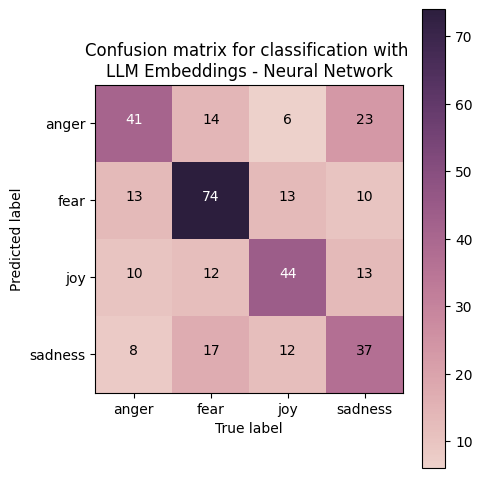

In [99]:
## check by confusion matrix
from sklearn.metrics import confusion_matrix

cm3 = confusion_matrix(
    y_true=label_decode(label_encoder, y_test_llama), y_pred=pred_result
)
my_tags = ["anger", "fear", "joy", "sadness"]
plot_confusion_matrix(
    cm3,
    classes=my_tags,
    title="Confusion matrix for classification with \nLLM Embeddings - Neural Network",
)

### ** >>> Exercise 12 (Take home): **

Follow Exercise 6 again and Plot the Training and Validation Accuracy and Loss for the results of this Neural Network. Compare the results of both KNN and the NN we just implemented. Discuss about why we obtained these results with the LLM Embeddings compared to the results of the other models implemented in this Lab.

<Axes: >

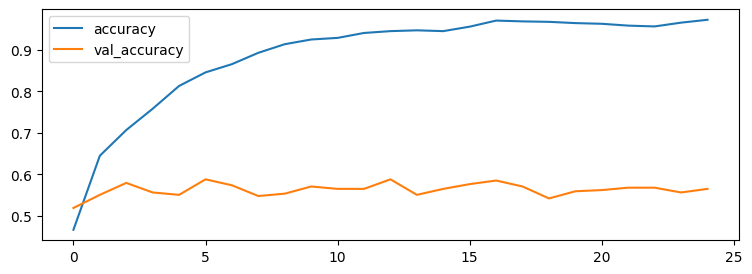

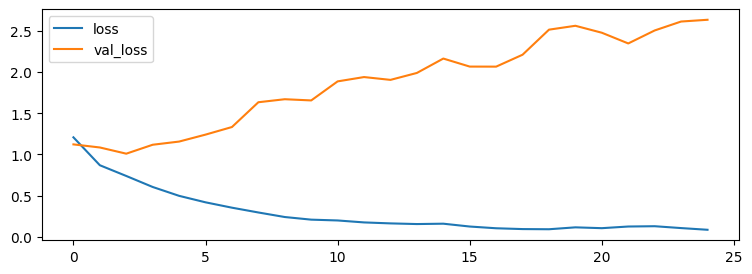

In [100]:
# Answer here
training_log[["accuracy", "val_accuracy"]].plot(figsize=[9,3])
training_log[["loss", "val_loss"]].plot(figsize=[9,3])

In terms of result, the accuracy of the NN classifier is better than that of the KNN classifier. But both their performances are inferior to the models trained with BOW preprocessing method. This is a unexpected result because LLM embedding is able to capture capture contextual information, while BOW does not.

One reason I came up with is the **curse of dimensions**. LLM embedding has 3072 dimensions, while BOW has 500 dimensions. Under the same setting, it is more difficult for a model to generalize a high-dimensional dataset.

### 10.5 Few-Shot Prompting Classification:
Few-shot prompting classification for LLMs involves giving the model a few labeled examples (typically 5 or fewer) within a prompt to guide it in performing a classification task. Instead of needing extensive training, the LLM uses these examples to understand the task and classify new inputs. This approach is significant in current research because it allows LLMs to perform well on tasks with minimal labeled data, reducing the need for large training datasets and making it highly flexible for various NLP tasks, including those in low-resource languages or niche domains.

In this lab exercise, we will explore zero-shot, 1-shot, and 5-shot prompting for classification using an LLM:

- Zero-shot means the model performs classification without seeing any examples beforehand.
- 1-shot provides the model with just one labeled example per class to guide its classification.
- 5-shot gives the model five labeled examples per class to improve its understanding of the task.

Since processing large datasets can be computationally demanding, we will only sample 20 test texts per emotion for the classification task, allowing us to test the model's performance more efficiently without using the entire test set.

**Process order: Explanation Prompt -> Examples + labels (if it is not zero-shot) -> Text to classify**

**Recommendation for the explanation prompt:** Explain to the model that it is a classification model of certain labels, and to only output the label word, and no other explanation. In this case if the model does not follow the instructions we are retrying the same text until it outputs one of the accepted labels for it.

In [108]:
import ollama
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the emotion labels
emotions = ["anger", "fear", "joy", "sadness"]
# Define the model to use for few-shot prompting
model_ollama = "llama3.2"


# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df["emotion"] == emotion].sample(
            n=num_samples, random_state=42
        )
    return few_shot_examples


# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    """

    prompt = classification_instructions + "\n\n"

    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nEmotion: {emotion}\n\n"  # Show the examples in the same format it will be shown for the classification text
                if (
                    num_shots == 1
                ):  # If 1-shot, break after the first example for each emotion
                    break
    return prompt


# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base):
    valid_emotions = ["anger", "fear", "joy", "sadness"]
    response = None
    while not response or response not in valid_emotions:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nEmotion: "  # The classification text will leave the emotion label to be filled in by the LLM
        result = client.chat(
            model=model_ollama, messages=[{"role": "user", "content": full_prompt}]
        )
        response = (
            result["message"]["content"].strip().lower()
        )  # Clean and standardize the response
        if response not in valid_emotions:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response


# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots)
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(
            None, emotions, num_shots=0
        )  # Zero-shot has no examples

    # Prepare to classify the test set
    predictions = []
    true_labels = []
    print("-----------------", prompt_base, "-----------------", sep="\n")
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=test_samples)

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in test_samples[emotion].iterrows():
            test_text = test_row["text"]
            predicted_emotion = classify_with_llm(test_text, prompt_base)
            predictions.append(predicted_emotion)
            true_labels.append(emotion)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))

    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions)
    my_tags = ["anger", "fear", "joy", "sadness"]
    plot_confusion_matrix(
        cm,
        classes=my_tags,
        title=f"Confusion matrix for classification with \n{num_shots}-shot prompting",
    )

-----------------

You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    


-----------------
Invalid response: frustration. Asking for reclassification.
Accuracy: 38.75%
              precision    recall  f1-score   support

       anger       0.27      0.45      0.34        20
        fear       0.75      0.15      0.25        20
         joy       0.50      0.70      0.58        20
     sadness       0.33      0.25      0.29        20

    accuracy                           0.39        80
   macro avg       0.46      0.39      0.36        80
weighted avg       0.46      0.39      0.36        80



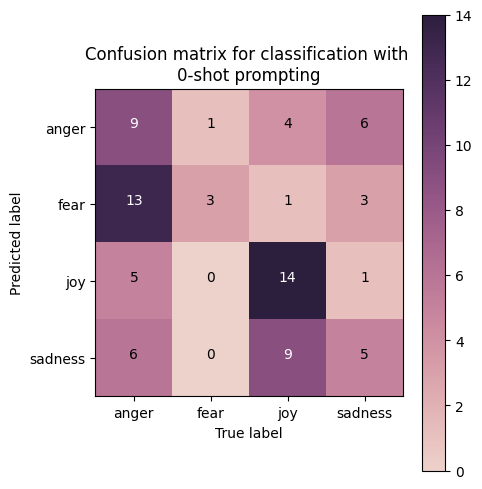

In [109]:
# Example of running the experiment with zero-shot prompting
run_experiment(df_train, df_test, test_samples=20, num_shots=0)

-----------------

You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    

Examples: 
Text: @cc_yandian @HillaryClinton her team must draw from a hat for daily personality #drugged  #yeller #quiet #screamer #😂😂
Emotion: anger

Text: @MrMalky @kwr66 How awful! Switched off!
Emotion: fear

Text: Make someone happy ^_^
Emotion: joy

Text: ya boy gets mad tired of pine trees
Emotion: sadness


-----------------
Accuracy: 45.00%
              precision    recall  f1-score   support

       anger       0.39      0.80      0.52        20
        fear       0.50      0.10      0.17        20
         joy       0.60      0.75      0.67        20
     sadness       0.30      0.15      0.20        20

    

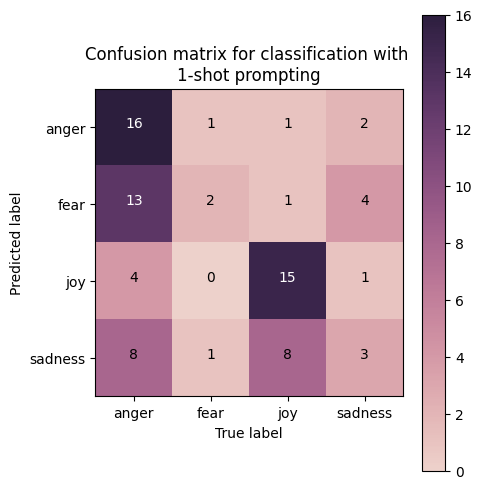

In [110]:
# Example of running the experiment with 1-shot prompting
run_experiment(df_train, df_test, test_samples=20, num_shots=1)

-----------------

You are an emotion classification model. You will be given a text from social media and your task is to classify the text into one of the following emotion categories: anger, fear, joy, or sadness.
You must only output one of these four labels. Do not provide any additional information or explanation. Just output the emotion label as one word.
    

Examples: 
Text: @cc_yandian @HillaryClinton her team must draw from a hat for daily personality #drugged  #yeller #quiet #screamer #😂😂
Emotion: anger

Text: seek to conduct attacks against Israel, intended to provoke a reaction that would further inflame feeling within the Islamic world”. •
Emotion: anger

Text: As if he heard my thought on the ether, my #ex has just posted #facebook pic of himself snuggling up with said #cats... now Im just #angry
Emotion: anger

Text: This provocation sets off a curiosity. An entity is feeding fuel to the fire. speaking quatrains. Hmmm America needs to be vigilant now
Emotion: anger

T

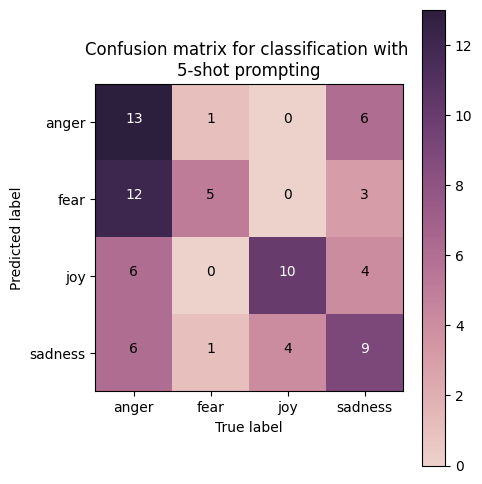

In [111]:
# Example of running the experiment with 5-shot prompting
run_experiment(df_train, df_test, test_samples=20, num_shots=5)

### ** >>> Exercise 13 (Take home): **

Compare and discuss the results of the zero-shot, 1-shot and 5-shot classification.

- **Accuracy**: zero-shot performs the worst. Both 1-shot and 5-shot improve the accurary, whereas the improvement between 1-shot and 5-shot is not as significant as that between zero-shot and 1-shot.
- **Analysis**: few-shot examples help the model to understand the format and the criteria of the tasks, making the model's outputs more aligned to our expectation. As the number of examples increases, the performance of the model is improved but the marginal improvement decreases. So there is an upper bound of the number of examples considering the cost and the performance.

### 10.6 Extra LLM Materials:
So this will be it for the lab, but here are some extra materials if you would like to explore:
- How to use Gemini's LLM API from Google: [Gemini Collab](https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/get-started/python.ipynb?fbclid=IwZXh0bgNhZW0CMTEAAR0-gg7cDIuaGfkeN5U3rusSNKj2jj7bIsL45sZWaM0NbTE7BSNtfzBeEGE_aem_yT5wAuL_G5E21iuuCYJXwA#scrollTo=hskqSKnJUHvp) (Free with some restrictions to the requests per minute.

- How to use OpenAI ChatGPT model's API (Not Free API): [Basics Video](https://www.youtube.com/watch?v=e9P7FLi5Zy8), [Basics GitHub](https://github.com/gkamradt/langchain-tutorials/blob/main/chatapi/ChatAPI%20%2B%20LangChain%20Basics.ipynb), [RAG's Basics Video](https://www.youtube.com/watch?v=9AXP7tCI9PI&t=300s), [RAG's Basics GitHub](https://github.com/techleadhd/chatgpt-retrieval)

- **Advanced topic - QLoRA (Quantized Low-Rank Adapter):** QLoRA is a method used to make fine-tuning large language models more efficient. It works by adding a small, trainable part (LoRA) to a pre-trained model, while keeping the rest of the model frozen. At the same time, it reduces the size of the model’s data using a process called quantization, which makes the model require less memory. This allows you to fine-tune large models without needing as much computational power, making it easier to adapt models for specific tasks. Materials: [Paper GitHub](https://github.com/artidoro/qlora?tab=readme-ov-file), [Llama 3 Application Video](https://www.youtube.com/watch?v=YJNbgusTSF0&t=512s),[Llama 3 Application GitHub](https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

---